# UMAP

In [ ]:
%pip install matplotlib seaborn
%pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
from pyspark.sql import *
from pyspark.sql.functions import *
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Demo 1: MNIST dataset

### Load dataset
Load and return OpenML's MNIST database of handwritten digits with 70,000 examples and 784 features across 10 classes, into a pandas DataFrame.   
(Note that while the default datatype is float64, UMAP does not support float64
computation, and will automatically convert inputs to float32 internally).

In [3]:
mnist = fetch_openml("mnist_784", version=1, parser='auto')
data = mnist.data
labels = mnist.target
print(data.shape)
data.info(memory_usage='deep')

(70000, 784)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


#### Split data into 75% train and 25% test

In [4]:
train_fraction = 0.75

shuffled_indices = np.random.permutation(len(data))
split_idx = int(train_fraction * len(shuffled_indices))
train_indices = shuffled_indices[:split_idx]
test_indices = shuffled_indices[split_idx:]

train_data = data.iloc[train_indices]
train_labels = labels.iloc[train_indices]

test_data = data.iloc[test_indices]
test_labels = labels.iloc[test_indices]

UMAP requires adequate memory on the driver during fit(), since the input data and embeddings are stored in the fitted model. Be sure to set `spark.driver.maxResultSize=0` to avoid serialization limits.

In [ ]:
assert spark.conf.get("spark.driver.maxResultSize") == "0"

#### Convert dataset to Spark DataFrame

In [7]:
"""Create train dataframe"""
train_df = spark.createDataFrame(train_data)
train_df.cache().count()

24/12/23 20:12:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/23 20:12:25 WARN TaskSetManager: Stage 0 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

52500

## Spark RAPIDS ML (GPU)

In [8]:
from spark_rapids_ml.umap import UMAP

In [11]:
feature_cols = [f"pixel{i}" for i in range(1, train_data.shape[1] + 1)]
umap_estimator = UMAP(num_workers=1).setFeaturesCols(feature_cols)

### Fit
Note that fit is executed on a single node.

In [12]:
start_time = time.time()
umap_model = umap_estimator.fit(train_df)
print(f"Fit took: {time.time() - start_time} sec")

INFO:spark_rapids_ml.umap.UMAP:Coalescing input dataset to one partition for fit() - logger.
24/12/23 20:13:20 WARN TaskSetManager: Stage 3 contains a task of very large size (321791 KiB). The maximum recommended task size is 1000 KiB.
2024-12-23 20:13:22,495 - spark_rapids_ml.umap.UMAP - INFO - Initializing cuml context
2024-12-23 20:13:23,546 - spark_rapids_ml.umap.UMAP - INFO - Loading data into python worker memory
2024-12-23 20:13:25,813 - spark_rapids_ml.umap.UMAP - INFO - Cuml fit complete
                                                                                

Fit took: 9.871629476547241 sec


#### Saving and loading
The UMAP estimator and model can be persisted using the PySpark save() API. Below is an example of saving and loading the model after fitting. The trained embeddings are retained. 

In [13]:
model_path = "/tmp/umap-model"
umap_model.write().overwrite().save(model_path)
umap_model_loaded = umap_model.load(model_path)
print("Model embedding shape:", len(umap_model_loaded.embedding), ",", len(umap_model_loaded.embedding[0]))

Model embedding shape: 52500 , 2


### Transform

In [14]:
"""Create test dataframe"""
feature_cols = [f"pixel{i}" for i in range(1, test_data.shape[1] + 1)]
test_df = spark.createDataFrame(test_data)
test_df.cache().count()

24/12/23 20:13:37 WARN TaskSetManager: Stage 8 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

17500

In [15]:
start_time = time.time()
df_output = umap_model.transform(test_df)
df_output.count()
print(f"Transform took: {time.time() - start_time} sec")

Transform took: 2.4740865230560303 sec


24/12/23 20:13:41 WARN TaskSetManager: Stage 11 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


#### Visualize embedding
Notice that UMAP maintains the local structure within classes while retaining the global structure between different digits. 
Groups of digits that can be visually similar, such as (4, 9) and (3, 5, 8) are embedded near each other, while distinct digits such as (0, 1) are placed far from each other.

24/12/23 20:13:45 WARN TaskSetManager: Stage 14 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

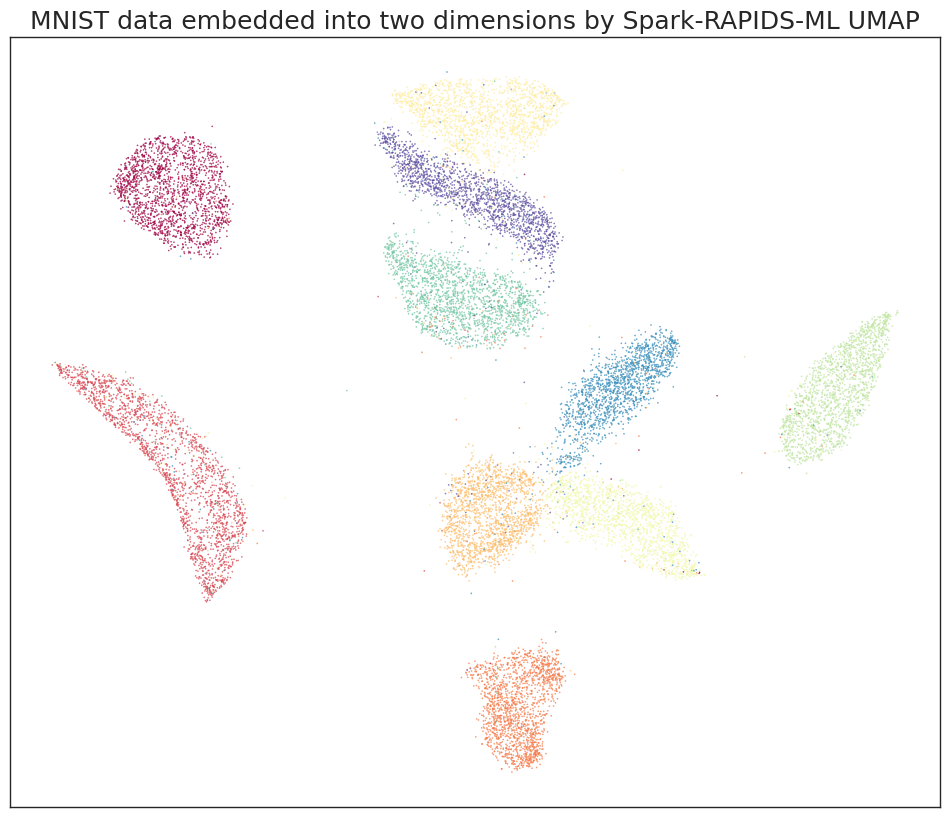

/tmp/ipykernel_838284/260446261.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


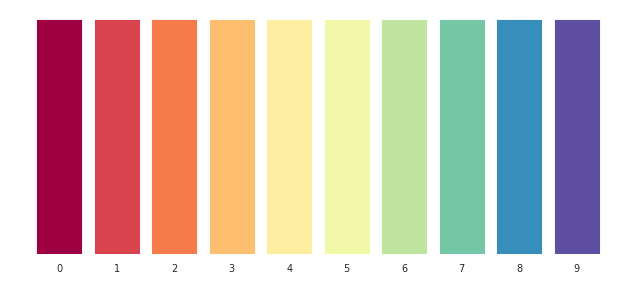

In [16]:
pd_output = df_output.toPandas()
embedding = np.array(pd_output["embedding"].to_list())

# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
color = test_labels.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by Spark-RAPIDS-ML UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

## UMAP (Local, CPU)

In [18]:
import umap as local_cpu_umap

In [19]:
local_umap = local_cpu_umap.UMAP()

### Fit

In [20]:
start_time = time.time()
local_umap.fit(train_data)
print(f"Fit took: {time.time() - start_time} sec")

/home/rishic/anaconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fit took: 11.432608127593994 sec


### Transform

In [21]:
start_time = time.time()
embedding = local_umap.transform(test_data)
print(f"Transform took: {time.time() - start_time} sec")

/home/rishic/anaconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Transform took: 6.4459028244018555 sec


### Visualize embedding

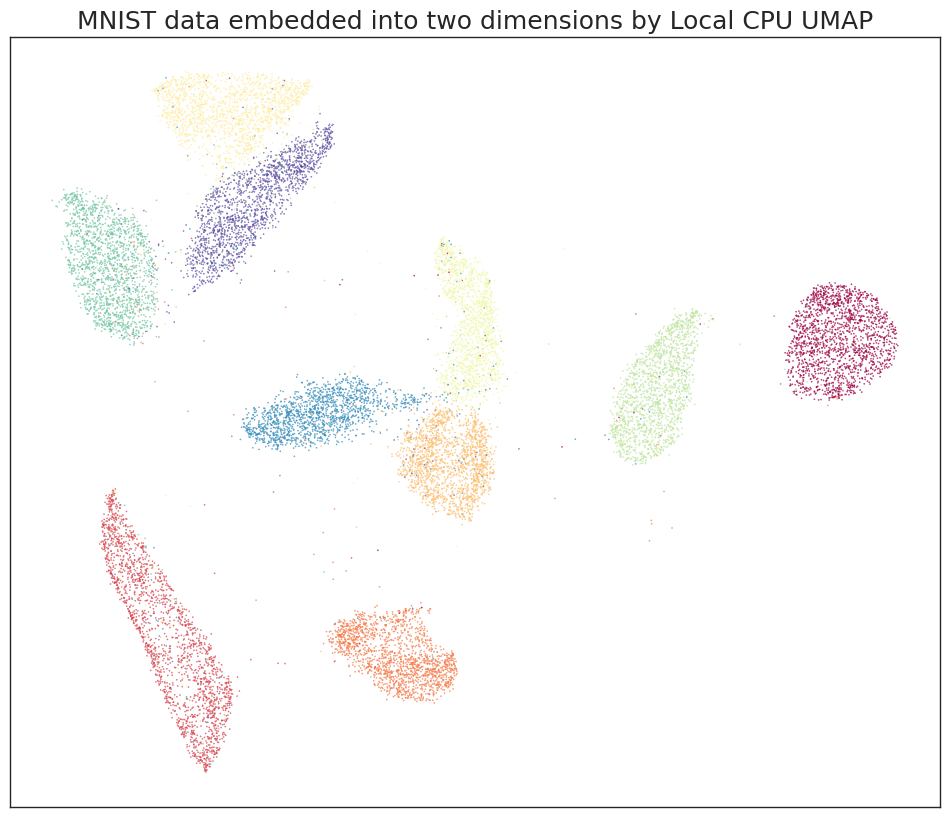

/tmp/ipykernel_838284/1393456941.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


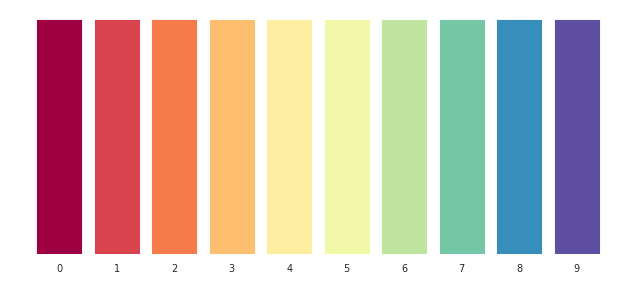

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
color = test_labels.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by Local CPU UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.colormaps.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

# Demo 2: Large blobs dataset
Here we demonstrate UMAP on a much larger synthetic clustering dataset.  

### Load dataset
By default, blobs creates a 3-class dataset.  
Be sure the driver has enough memory to handle the resultant model and embeddings. Adjust --num_rows and --num_cols accordingly. 

In [ ]:
!python ../python/benchmark/gen_data_distributed.py blobs --num_rows 100000 --num_cols 3000 --dtype float32 --output_dir "./blobs_100k_3k_f32.parquet" --feature_type array --include_labels true --overwrite --output_num_files 20 --spark_confs spark.driver.memory=20g --spark_confs spark.master=local[16]

## Spark RAPIDS ML (GPU)

In [27]:
blobs_df = spark.read.parquet("blobs_100k_3k_f32.parquet")
umap_estimator = UMAP(num_workers=1).setFeaturesCol("feature_array").setSampleFraction(0.5) # We will use 50% of the data for training.

In [28]:
blobs_df.cache()
blobs_df.show()

+-----+--------------------+
|label|       feature_array|
+-----+--------------------+
|  2.0|[1.1225425, 8.090...|
|  2.0|[1.3952645, 10.13...|
|  1.0|[5.6613383, -10.6...|
|  1.0|[6.663165, -10.55...|
|  2.0|[3.3295357, 7.056...|
|  1.0|[5.9030476, -8.53...|
|  0.0|[-1.9585358, 4.08...|
|  2.0|[3.3657835, 7.360...|
|  0.0|[-1.2942472, 3.08...|
|  0.0|[-0.71991915, 3.2...|
|  2.0|[2.7703717, 7.824...|
|  0.0|[-1.613434, 4.254...|
|  2.0|[2.7990475, 7.251...|
|  0.0|[-0.8813253, 5.28...|
|  2.0|[3.7175896, 9.955...|
|  2.0|[3.9080243, 8.451...|
|  0.0|[-1.6275891, 6.58...|
|  2.0|[3.987125, 6.7194...|
|  2.0|[3.257498, 7.3159...|
|  1.0|[6.780314, -8.829...|
+-----+--------------------+
only showing top 20 rows



24/12/23 20:16:47 WARN CacheManager: Asked to cache already cached data.


### Fit

In [29]:
start_time = time.time()
umap_model = umap_estimator.fit(blobs_df)
print(f"Fit took: {time.time() - start_time} sec")

INFO:spark_rapids_ml.umap.UMAP:Coalescing input dataset to one partition for fit() - logger.
2024-12-23 20:16:49,651 - spark_rapids_ml.umap.UMAP - INFO - Initializing cuml context
2024-12-23 20:16:52,607 - spark_rapids_ml.umap.UMAP - INFO - Loading data into python worker memory
2024-12-23 20:16:57,665 - spark_rapids_ml.umap.UMAP - INFO - Cuml fit complete
                                                                                

Fit took: 17.313908338546753 sec


### Transform

In [30]:
start_time = time.time()
df_output = umap_model.transform(blobs_df)
df_output.count()
print(f"Transform took: {time.time() - start_time} sec")

Transform took: 0.7500905990600586 sec


### Visualize embedding
The 100,000 samples with 3000 features are mapped into 3 distinct clusters in 2 dimensions.

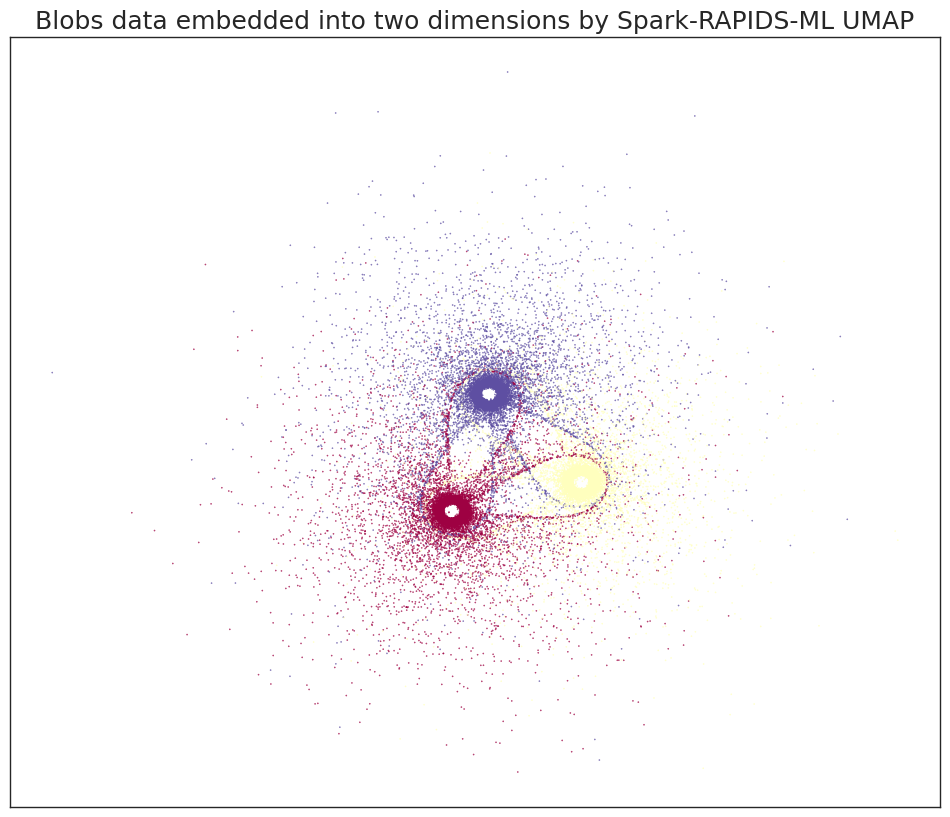

In [31]:
pd_output = df_output.toPandas()
embedding = np.array(pd_output["embedding"].to_list())

# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
color = blobs_df.select("label").toPandas()["label"].values.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Blobs data embedded into two dimensions by Spark-RAPIDS-ML UMAP", fontsize=18)
plt.show()

## UMAP (Local, CPU)

In [32]:
local_umap = local_cpu_umap.UMAP()

### Convert dataframe to numpy

In [33]:
blobs_singlecol = blobs_df.drop("label").toPandas().to_numpy()
blobs = np.array([array[0] for array in blobs_singlecol], dtype=np.float32)
print(blobs.shape)

(100000, 3000)


In [34]:
train_fraction = 0.5

shuffled_indices = np.random.permutation(blobs.shape[0])
split_idx = int(train_fraction * len(shuffled_indices))
sampled_indices = shuffled_indices[:split_idx]

blobs_train = blobs[sampled_indices]
print(blobs_train.shape)

(50000, 3000)


### Fit

In [35]:
start_time = time.time()
local_umap.fit(blobs_train)
print(f"Fit took: {time.time() - start_time} sec")

/home/rishic/anaconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fit took: 16.89190697669983 sec


### Transform

In [36]:
start_time = time.time()
embedding = local_umap.transform(blobs)
print(f"Transform took: {time.time() - start_time} sec")

/home/rishic/anaconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Transform took: 1023.351279258728 sec


### Visualize embedding

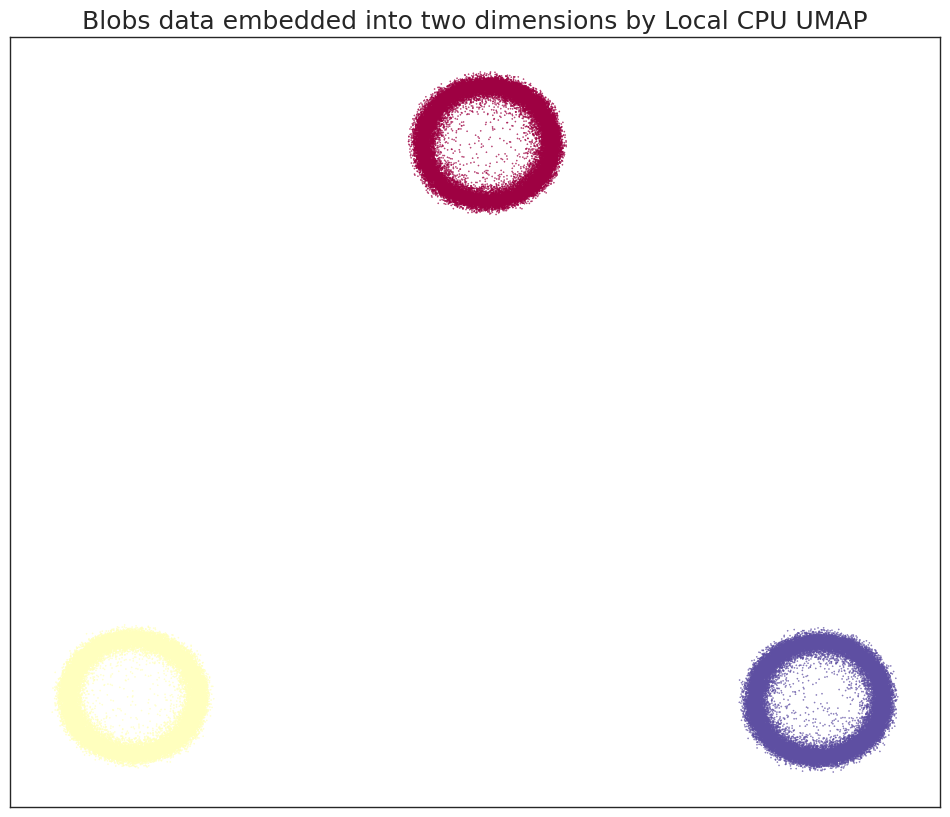

In [37]:
# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
color = blobs_df.select("label").toPandas()["label"].values.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Blobs data embedded into two dimensions by Local CPU UMAP", fontsize=18)
plt.show()

Note that there may be visualization differences above, as reported in this [issue](https://github.com/lmcinnes/umap/issues/775).  
This is due to inherent differences in the CPU and GPU implementations, and can be the result of numerical instability due to the high parallelism in the GPU algorithm.